# Pull-Up Rate EDA and Model
In this notebook, I will explore the relationships of different player stats and their future pull-up rate.  

Goals:
- Look for what stats might best predict pull-up rate.
- Find the best model to make accurate predictions.

Conclusions: 
- Like other rates, future pull-up rates are almost entirely related to past pull-up rates.

## 0. Importing Libraries and Data

In [2]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [4]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['PULL_UP_FGA'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [5]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['PULL_UP_RATE'])

In [6]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_PULL_UP_RATE']]
X = data.drop(columns='TARGET_PULL_UP_RATE')

#### Splitting X and y into train, validate, and test sets

In [7]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'PULL_UP_RATE')

## 2. Determine Potential Features
- Shooting off the dribble rates are clearly important
- Some of the stats are related to players who have the ball a lot (seconds per touch, usage)

#### Finding correlated features

In [8]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [9]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [10]:
# Looking at the most correlated features with the target
corr_features

['PULL_UP_FGA_PER_MIN_WEIGHTED',
 'PULL_UP_RATE_WEIGHTED',
 'PULL_UP_FGA_PER_MIN',
 'PULL_UP_RATE',
 'PULL_UP_FGM_PER_MIN_WEIGHTED',
 'PULL_UP_PTS_PER_MIN_WEIGHTED',
 'PULL_UP_PTS_PER_MIN',
 'PULL_UP_FGM_PER_MIN',
 'PULL_UP_FGA_WEIGHTED',
 'PULL_UP_FGA']

In [11]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_PULL_UP_RATE'], alpha=.5)

#### Graphing correlated features

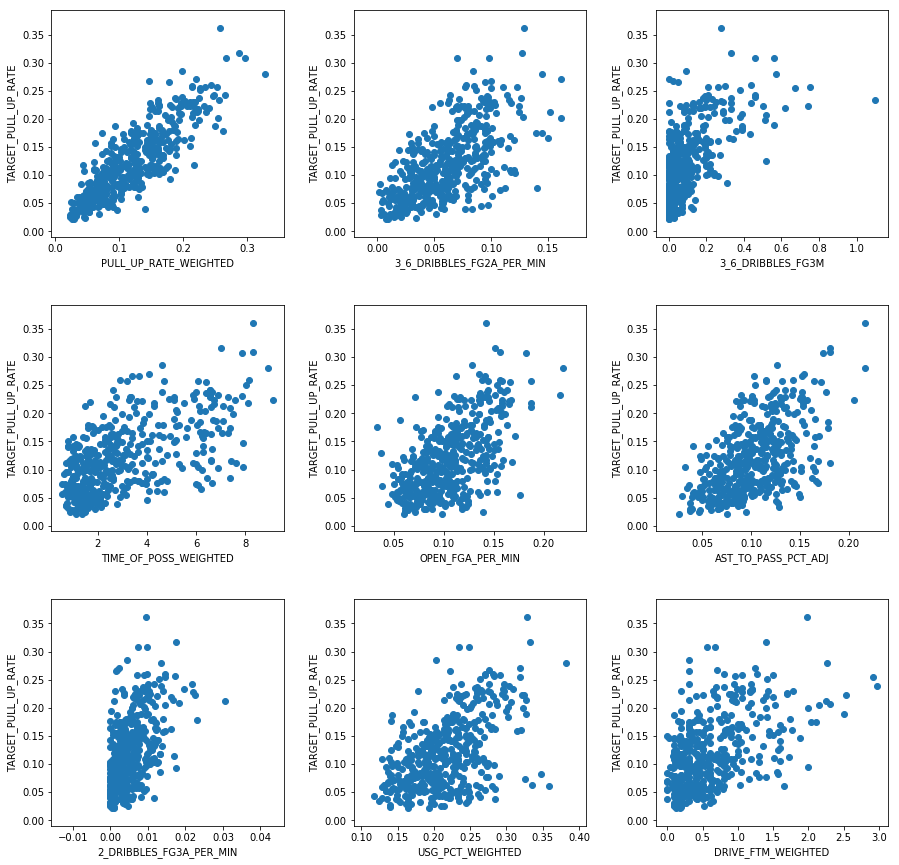

In [12]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

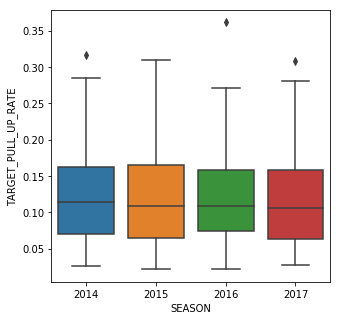

In [13]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

#### Looking at driving and age

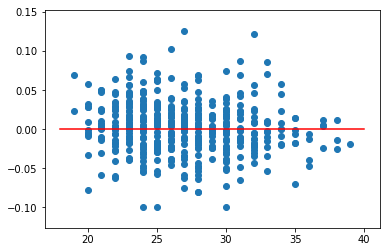

In [15]:
plt.scatter(X_train['AGE'], y_train['TARGET_PULL_UP_RATE'] - X_train['PULL_UP_RATE'])
plt.plot([18,40], [0,0], color='r');

## 3. Modeling

#### RFECV
- Used a lot of features.
- Score was high compared to past model (for other targets).

In [16]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

20

In [17]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['3_6_DRIBBLES_FGA_FREQUENCY', '3_6_DRIBBLES_FG2A_FREQUENCY',
       '3_6_DRIBBLES_FG3A_FREQUENCY', 'OREB_CONTEST_PER_MIN',
       'DREB_CONTEST_PER_MIN', 'REB_CONTEST_PER_MIN',
       'ELBOW_TOUCH_FTM_PER_MIN', 'POST_TOUCH_TOV_PER_MIN',
       'TIGHT_FGM_PER_MIN', 'TIGHT_FG2M_PER_MIN', 'TIGHT_FG3M_PER_MIN',
       '3_6_DRIBBLES_FGM_PER_MIN', '3_6_DRIBBLES_FG2M_PER_MIN',
       '3_6_DRIBBLES_FG3M_PER_MIN', 'OREB_CONTEST_PER_MIN_WEIGHTED',
       'OREB_CHANCE_DEFER_PER_MIN_WEIGHTED', 'DREB_CONTEST_PER_MIN_WEIGHTED',
       'REB_CONTEST_PER_MIN_WEIGHTED', 'PULL_UP_FGM_PER_MIN_WEIGHTED',
       'POST_TOUCH_TOV_PER_MIN_WEIGHTED'],
      dtype='object')

In [18]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.6869618363115999

#### K BEST
- Surprisingly, the scores got worse as the number of features increased.
- Just using the current season pull-up rate seemed to get the best score.

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarnin

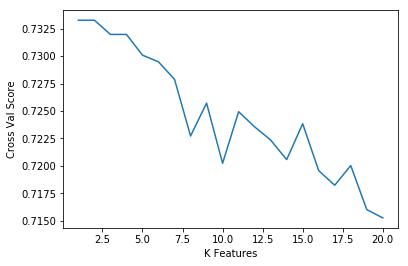

In [21]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 21):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1, 21), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

1  Feature Cross Val Scores:  [0.75720067 0.66802692 0.79172577 0.69838207 0.75100474]
2  Feature Cross Val Scores:  [0.75720067 0.66802692 0.79172577 0.69838207 0.75100474]
3  Feature Cross Val Scores:  [0.75505757 0.66788505 0.78988433 0.69602684 0.75102767]
4  Feature Cross Val Scores:  [0.75505757 0.66788505 0.78988433 0.69602684 0.75102767]
5  Feature Cross Val Scores:  [0.75565615 0.66389869 0.78705301 0.69443675 0.74938152]
6  Feature Cross Val Scores:  [0.75494454 0.66351573 0.78646085 0.69346621 0.74899192]
7  Feature Cross Val Scores:  [0.75402485 0.6513456  0.78794057 0.69640775 0.7496931 ]


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

8  Feature Cross Val Scores:  [0.75399181 0.63300481 0.7839721  0.69352731 0.7491043 ]
9  Feature Cross Val Scores:  [0.75601217 0.64261629 0.79045425 0.69657301 0.74293328]
10  Feature Cross Val Scores:  [0.75630623 0.6416255  0.79034951 0.66992059 0.74295076]
11  Feature Cross Val Scores:  [0.75651914 0.65870398 0.80199568 0.66254621 0.74489693]


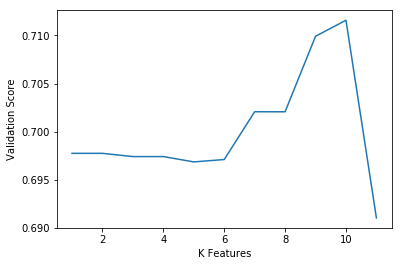

In [22]:
# Checking out 1-11 features
k_scores = []
for k in range(1,12):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 12), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [26]:
# Printing out the scores with 1 features
k_best = SelectKBest(f_regression, k=1)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.697761080952332

In [27]:
# Printing the model features
model_features

['PULL_UP_FGA_PER_MIN_WEIGHTED']

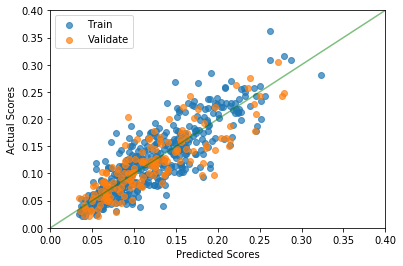

In [25]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### PCA
- The elbow method (pusing 2 features in this case) worked reasonably well.
- The model was clearly worse than others.

In [29]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.30187874, 0.17455274, 0.08396675, 0.04364809, 0.03122627,
       0.02581948, 0.0220262 , 0.0189501 , 0.01685003, 0.01551235,
       0.01385355, 0.01257991, 0.0106228 , 0.00986813, 0.00955071])

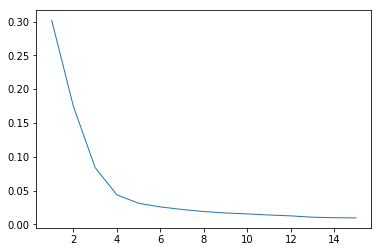

In [30]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [31]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.5775337 , 0.43683785, 0.56284457, 0.50639986, 0.61515176])

In [32]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.5429161604538186

#### Neural Net
- Graph has a strange pattern. Higher and low predicted scores had a lot of variance in true scores.
- Performed worse than other models.

In [33]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [34]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [35]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [36]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

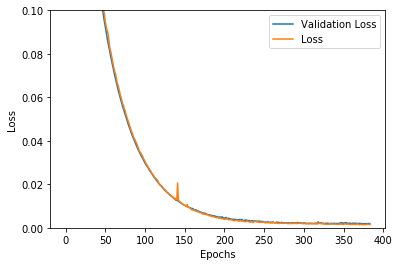

In [37]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [38]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.4693591749165361

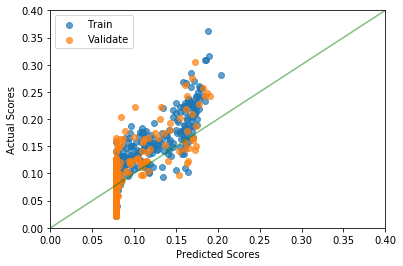

In [39]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores seem similar to the 1 feature model.

In [40]:
# Saving the model features
model_features = ['PULL_UP_EV_WEIGHTED', 'CATCH_SHOOT_EV', 'CATCH_SHOOT_RATE_WEIGHTED', 'DRIVE_RATE_WEIGHTED',
                  'POST_TOUCH_RATE_WEIGHTED', 'PULL_UP_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015',
                  '2016', '2017']

In [41]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.75169169, 0.66713252, 0.78235128, 0.70502181, 0.74920563])

In [42]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.7151346308590667

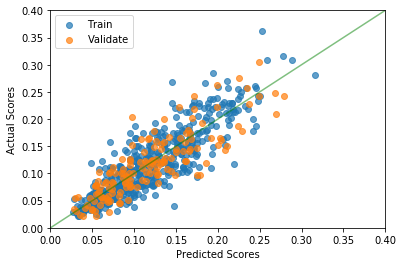

In [43]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### Regularized Linear Regression with My Selected Features
- These scores are very similar to the linear regression.
- Weighted pull-up rate dominated both of their predictions.

In [44]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [45]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.75163419, 0.66714607, 0.78227395, 0.70513448, 0.74921968])

In [46]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.715264680740316

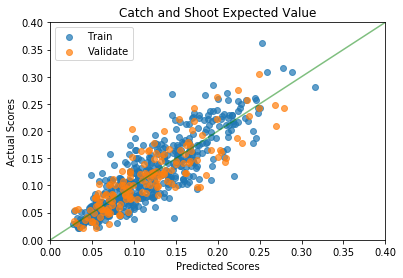

In [47]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=.4)
plt.title('Catch and Shoot Expected Value');

In [48]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.72482481, 0.67090791, 0.75431052, 0.68495154, 0.71120461])

In [49]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.7100493804080745

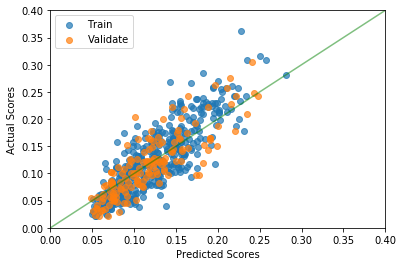

In [50]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=.4)

In [51]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
PULL_UP_EV_WEIGHTED,0.000000,-0.000060
CATCH_SHOOT_EV,0.000000,0.002367
CATCH_SHOOT_RATE_WEIGHTED,-0.000000,-0.001551
DRIVE_RATE_WEIGHTED,0.000000,0.003241
POST_TOUCH_RATE_WEIGHTED,-0.000000,0.000387
PULL_UP_RATE_WEIGHTED,0.044498,0.051584
PLAYER_HEIGHT_INCHES,-0.000000,-0.000464
SKINNY,0.000000,0.000928
AGE,-0.000000,-0.003246
2015,-0.000000,-0.001584


#### Final scores (Ridge)
- The r2 score on the test set was quite high given the model scores.
- There was a 5.9 percent improvement in the rmse compared to the baseline using the test set.

In [52]:
# Ridge score on test data
X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, ridge.predict(X_test_scaled))

0.708618098531931

In [53]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.03475488890702627

In [54]:
# The score if the prediction was just the value from the current year 
baseline = mean_squared_error(y_test, X_test['PULL_UP_RATE']) ** .5
baseline

0.036943436142711825

In [55]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

0.05924048935868431

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [56]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_PULL_UP_RATE'] = ridge.predict(X_train_scaled)

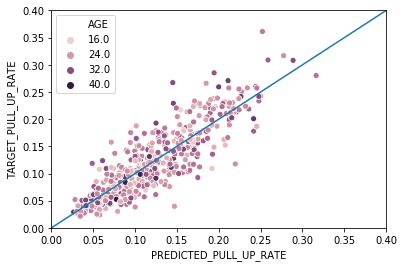

In [57]:
sns.scatterplot('PREDICTED_PULL_UP_RATE', 'TARGET_PULL_UP_RATE', data=train, hue='AGE')
plt.plot([0,.4], [0,.4])
plt.xlim(0, .4)
plt.ylim(0, .4);

#### Saving the predictions

In [76]:
# Loading the target dataframe
target_df = pd.read_csv('./data/target_df', index_col=0)

In [77]:
# Adding the predictions to the target dataframe
master_scaled = scaler.transform(master_df[model_features].dropna())
predictions = ridge.predict(master_scaled)
predictions_index = master_df[model_features].dropna().index
predictions_df = pd.DataFrame(predictions, columns=['PRED_PULL_UP_RATE'], index=predictions_index)
target_df = pd.merge(target_df, predictions_df, how='left', left_index=True, right_index=True)

In [78]:
# Saving the dataframe
target_df.to_csv('./data/target_df')